In [1]:
import numpy as np
import pandas as pd
import torch
from gcn_model import GCNModel
import utilities
from test_model import test_model
import os
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from test_model import test_model

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#remove cd34 cells
ref_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv", index_col=0)
ref_counts = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref.csv", index_col=0)
print(ref_counts.shape)
print(ref_labels.shape)
print(ref_labels[ref_labels.labels=="cd34"].shape)
ref_counts = ref_counts.drop(ref_labels[ref_labels.labels=="cd34"].index)
ref_labels = ref_labels.drop(ref_labels[ref_labels.labels=="cd34"].index)
ref_counts.columns = ref_counts.columns.str.split("\t").str[1]
print(ref_labels.shape)
print(ref_counts.shape)
ref_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv")
ref_counts.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref.csv")

(4733, 32738)
(4733, 1)
(463, 1)
(4270, 1)
(4270, 32738)


In [4]:
#remove cd34 cells
query_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv", index_col=0)
query_counts = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query.csv", index_col=0)
print(query_counts.shape)
print(query_labels.shape)
print(query_labels[query_labels.labels=="cd34"].shape)
query_counts = query_counts.drop(query_labels[query_labels.labels=="cd34"].index)
query_labels = query_labels.drop(query_labels[query_labels.labels=="cd34"].index)
query_counts.columns = query_counts.columns.str.split("\t").str[1]
print(query_labels.shape)
print(query_counts.shape)
query_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv")
query_counts.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query.csv")

(4733, 32738)
(4733, 1)
(486, 1)
(4247, 1)
(4247, 32738)


In [12]:
ref_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv", index_col=0)
print(ref_labels['labels'].unique())
ref_labels['labels'] = ref_labels['labels'].replace("cytotoxic_t","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("regulatory_t","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("cd4_t_helper","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("naive_cytotoxic","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("memory_t","t_cell")
ref_labels['labels'] = ref_labels['labels'].replace("naive_t","t_cell")
print(ref_labels['labels'].unique())
ref_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels_tcombined.csv")

['b_cells' 'cytotoxic_t' 'regulatory_t' 'cd4_t_helper' 'naive_cytotoxic'
 'cd56_nk' 'memory_t' 'naive_t' 'cd14_monocytes']
['b_cells' 't_cell' 'cd56_nk' 'cd14_monocytes']


In [13]:
query_labels = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv", index_col=0)
print(query_labels['labels'].unique())
query_labels['labels'] = query_labels['labels'].replace("cytotoxic_t","t_cell")
query_labels['labels'] = query_labels['labels'].replace("regulatory_t","t_cell")
query_labels['labels'] = query_labels['labels'].replace("cd4_t_helper","t_cell")
query_labels['labels'] = query_labels['labels'].replace("naive_cytotoxic","t_cell")
query_labels['labels'] = query_labels['labels'].replace("memory_t","t_cell")
query_labels['labels'] = query_labels['labels'].replace("naive_t","t_cell")
print(query_labels['labels'].unique())
query_labels.to_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels_tcombined.csv")

['cytotoxic_t' 'naive_cytotoxic' 'cd56_nk' 'b_cells' 'naive_t' 'memory_t'
 'regulatory_t' 'cd4_t_helper' 'cd14_monocytes']
['t_cell' 'cd56_nk' 'b_cells' 'cd14_monocytes']


In [8]:
# check no overlap with held out set
ref_ids = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/ref_labels.csv", index_col=0).index
query_ids = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/query_labels.csv", index_col=0).index
big_ids = pd.read_csv("/home/groups/ConradLab/daniel/sharp_data/pbmc_10x/bigger_split_labels.csv", index_col=0).index

In [9]:
print(ref_ids.isin(big_ids).any())
print(query_ids.isin(big_ids).any())
print(query_ids.isin(ref_ids).any())

False
False
False


In [10]:
ref_counts.columns.isin(["CD8B"]).any()

True

In [22]:
data_folder = "/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/"
# get labels
data_path = data_folder + "query.csv"
#tools = ["sctype","scsorter","scina","singler", "scpred"]
tools = ["scsorter","scina","sctype"]
ref_path = data_folder + "ref.csv"
ref_label_path = data_folder + "ref_labels_tcombined.csv"
marker_path = data_folder + "markers_cd4-8.txt"
if os.path.exists(data_folder + "preds_3kref_cd4-8.csv"):
    all_labels = pd.read_csv(data_folder + "preds_3kref_cd4-8.csv", index_col=0)
    if all_labels.shape[1] != len(tools): 
        all_labels = all_labels[tools]
        #raise Exception("wrong amount of tools in file")
else:
    all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

# read in dataset
counts = pd.read_csv(data_path, index_col=0)
X, keep_cells, keep_genes, pca_obj = utilities.preprocess(np.array(counts), scale=False, comps=500)

all_labels = all_labels.loc[keep_cells,:]

_,marker_names = utilities.read_marker_file(marker_path)

all_labels_factored = utilities.factorize_df(all_labels, marker_names)
encoded_labels = utilities.encode_predictions(all_labels_factored)

confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .51)

meta_path = data_folder + "query_labels_cd4-8.csv"
metadata = pd.read_csv(meta_path, index_col=0)
real_y,cell_names = pd.factorize(metadata['labels'], sort=True)
real_y = real_y[keep_cells]

train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]
print(cell_names)

Index(['b_cells', 'cd14_monocytes', 'cd4_t_cell', 'cd56_nk', 'cd8_t_cell'], dtype='object')


In [23]:
len(test_nodes)

300

In [24]:
confusion_matrix(real_y[train_nodes], confident_labels[train_nodes])

array([[ 483,    0,    0,    0,    0],
       [   1,  116,    0,    0,    0],
       [   3,    1, 1788,    0,   40],
       [   1,    0,    1,  381,    4],
       [   0,    0,   95,    2, 1030]])

In [25]:
confusion_matrix(real_y, all_labels_factored['scina'])

array([[   0,    0,    0,    0,    0,    0],
       [  30,  453,    0,    0,    0,    0],
       [  56,    0,   68,    0,    0,    0],
       [ 472,   20,    2, 1568,    0,   12],
       [ 178,    2,    0,    1,  235,    0],
       [  86,   16,    2,  264,   13,  768]])

In [26]:
confusion_matrix(real_y, all_labels_factored['sctype'])

array([[ 483,    0,    0,    0,    0],
       [   1,  123,    0,    0,    0],
       [   0,    1, 2008,    1,   64],
       [   0,    0,    3,  408,    5],
       [   0,    0,   67,    2, 1080]])

In [27]:
confusion_matrix(real_y, all_labels_factored['scsorter'])

array([[   0,    0,    0,    0,    0,    0],
       [   6,  477,    0,    0,    0,    0],
       [  10,    6,  106,    2,    0,    0],
       [  47,    4,    0, 1020,    0, 1003],
       [  70,    1,    1,    2,  309,   33],
       [   4,    0,    0,   95,    0, 1050]])

In [28]:
confusion_matrix(real_y, all_labels_factored['singler'])

array([[   0,    0,    0,    0,    0,    0],
       [   4,  479,    0,    0,    0,    0],
       [   1,    0,  123,    0,    0,    0],
       [  11,    0,    0, 2053,    0,   10],
       [  14,    0,    0,   19,  203,  180],
       [   0,    0,    0, 1056,    1,   92]])

In [29]:
confusion_matrix(real_y, all_labels_factored['scpred'])

array([[   0,    0,    0,    0,    0,    0],
       [   0,  483,    0,    0,    0,    0],
       [   0,    1,  123,    0,    0,    0],
       [  11,    0,    1, 2025,    0,   37],
       [  29,    0,    0,    2,  347,   38],
       [   5,    0,    0,  981,    1,  162]])

In [25]:
print(utilities.pred_accuracy(all_labels_factored['scina'], real_y))
print(utilities.pred_accuracy(all_labels_factored['sctype'], real_y))
print(utilities.pred_accuracy(all_labels_factored['scsorter'], real_y))
#print(utilities.pred_accuracy(all_labels_factored['singler'], real_y))
#print(utilities.pred_accuracy(all_labels_factored['scpred'], real_y))
max_pred = torch.tensor(encoded_labels).max(dim=1)[1]
print(utilities.pred_accuracy(max_pred, real_y))

0.7282148003578186
0.9660857319831848
0.6975977420806885
0.9550164937973022


/home/users/lewinsda/scSHARP/utilities.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


In [26]:
print(utilities.pred_accuracy(np.array(all_labels_factored['scina'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['sctype'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['scsorter'][test_nodes]), real_y[test_nodes]))
#print(utilities.pred_accuracy(np.array(all_labels_factored['singler'][test_nodes]), real_y[test_nodes]))
#print(utilities.pred_accuracy(np.array(all_labels_factored['scpred'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(max_pred[test_nodes], real_y[test_nodes]))

0.0
0.9466666579246521
0.046666666865348816
0.8566666841506958


In [27]:
dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

In [8]:
torch.cuda.is_available()

True

In [28]:
m = GCNModel("configs/2_40_5.txt", 2, dropout=0.0)
m.train(dataloader, 150)

Loss in epoch 0 = 60.115742
Loss in epoch 10 = 0.106982
Loss in epoch 20 = 0.012560
Loss in epoch 30 = 0.004222
Loss in epoch 40 = 0.002811
Loss in epoch 50 = 0.001143
Loss in epoch 60 = 0.000726
Loss in epoch 70 = 0.000370
Loss in epoch 80 = 0.000196
Loss in epoch 90 = 0.000130
Loss in epoch 100 = 0.000079
Loss in epoch 110 = 0.000052
Loss in epoch 120 = 0.000028
Loss in epoch 130 = 0.000020
Loss in epoch 140 = 0.000011


In [43]:
m.validation_metrics(test_dataloader, train_nodes, test_nodes)

(0.9590202569961548,
 array([[ 483,    0,    0,    0,    0],
        [   1,  123,    0,    0,    0],
        [   4,    1, 2012,    0,   57],
        [   1,    0,    2,  409,    4],
        [   0,    0,  102,    2, 1045]]),
 0.9624936580657959,
 array([[ 483,    0,    0,    0,    0],
        [   1,  116,    0,    0,    0],
        [   3,    1, 1788,    0,   40],
        [   1,    0,    1,  381,    4],
        [   0,    0,   95,    2, 1030]]),
 0.9133333563804626,
 array([[  0,   0,   0,   0,   0],
        [  0,   7,   0,   0,   0],
        [  1,   0, 224,   0,  17],
        [  0,   0,   1,  28,   0],
        [  0,   0,   7,   0,  15]]))

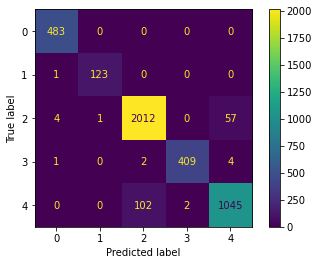

In [38]:
ConfusionMatrixDisplay(total_m).plot()

In [13]:
ultra_confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .9)
ultra_conf_nodes = np.where(ultra_confident_labels != -1)[0]
weights = np.zeros((5,5))
for type in [0,1,2,3,4]:
    
    type_indices = np.where(confident_labels[ultra_conf_nodes]==type)[0]
    for i, tool in enumerate(all_labels_factored.columns):
        weights[type,i] = utilities.pred_accuracy(all_labels_factored[tool].to_numpy()[ultra_conf_nodes][type_indices], confident_labels[ultra_conf_nodes][type_indices])
weights

array([[0.9359504 , 0.98553717, 1.        , 0.98966944, 1.        ],
       [0.57758623, 0.91379309, 1.        , 0.99137932, 1.        ],
       [0.77582848, 0.95614034, 1.        , 0.99220276, 0.99415207],
       [0.70918369, 0.85204083, 1.        , 0.95918369, 0.97959185],
       [0.60869563, 0.97826087, 1.        , 1.        , 0.97826087]])

In [21]:
confusion_matrix(ultra_confident_labels[ultra_conf_nodes], all_labels_factored['scpred'][ultra_conf_nodes])

array([[   0,    0,    0,    0,    0,    0],
       [   0,  484,    0,    0,    0,    0],
       [   0,    0,  116,    0,    0,    0],
       [   6,    0,    0, 1020,    0,    0],
       [   4,    0,    0,    0,  192,    0],
       [   1,    0,    0,    0,    0,   45]])

In [20]:
 all_labels_factored['scpred'][ultra_conf_nodes]

6       0
7       0
10      2
11      0
13      3
       ..
4240    0
4241    2
4242    2
4243    2
4245    2
Name: scpred, Length: 1868, dtype: int64

In [14]:
all_labels_factored.columns

Index(['scina', 'scsorter', 'sctype', 'singler', 'scpred'], dtype='object')

In [ ]:
new_encoded = utilities.weighted_encode(all_labels_factored, encoded_labels, weights,.5)
confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .51)

train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]

In [ ]:
len(test_nodes)

In [ ]:
confusion_matrix(real_y[train_nodes], confident_labels[train_nodes])

In [ ]:
dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

In [ ]:
m = GCNModel("configs/2_40.txt", 2, dropout=0.0)
m.train(dataloader, 150)

In [ ]:
m.validation_metrics(test_dataloader, train_nodes, test_nodes)

In [47]:
np.unique(real_y[test_nodes])

array([2, 3, 4])

In [30]:
preds,_ = m.predict(test_dataloader)
final_preds = preds.max(dim=1)[1]
genes = counts.columns.to_numpy()[keep_genes]

In [40]:
int_df = utilities.run_interpretation(m, X, pca_obj, final_preds, genes)

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


[Text(0.5, 14.09375, 'Cell Type')]

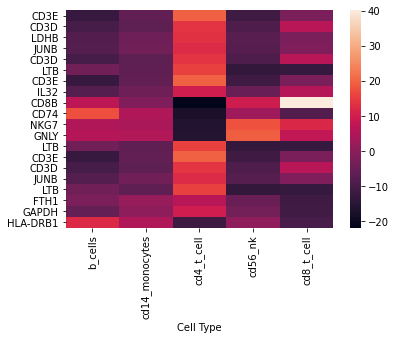

In [41]:
keep_genes = int_df.sort_values(0, ascending=True).head(4).index.tolist()
keep_genes += int_df.sort_values(1, ascending=True).head(4).index.tolist()
keep_genes += int_df.sort_values(2, ascending=True).head(4).index.tolist()
keep_genes += int_df.sort_values(3, ascending=True).head(4).index.tolist()
keep_genes += int_df.sort_values(4, ascending=True).head(4).index.tolist()
int_df.columns = cell_names
ax = sns.heatmap(int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [29]:
int_df.loc[keep_genes,:]

,b_cells,cd14_monocytes,cd34,cd4_t_cell,cd56_nk,cd8_t_cell
CD74,23.028280,7.844861,7.117867,-23.998674,0.484068,-10.958111
HLA-DRA,20.550703,6.641532,7.058403,-20.337034,-0.839501,-11.454344
HLA-DRB1,18.000893,6.987773,3.675694,-15.676343,-0.664304,-11.306343
HLA-DPB1,16.351137,5.507708,4.831303,-16.857906,-0.593052,-7.320463
TYROBP,1.064735,8.092411,5.520627,-11.201632,12.154108,-5.426261
CD74,23.028280,7.844861,7.117867,-23.998674,0.484068,-10.958111
HLA-DRB1,18.000893,6.987773,3.675694,-15.676343,-0.664304,-11.306343
HLA-DRA,20.550703,6.641532,7.058403,-20.337034,-0.839501,-11.454344
GSTP1,1.188442,3.734811,7.499246,-9.217718,4.667435,-3.152863
AIF1,1.021200,3.756367,7.169282,-11.614655,1.482419,2.128209


In [34]:
int_df.loc["CD4",:]

b_cells          -0.781815
cd14_monocytes    0.133937
cd34             -0.302833
cd4_t_cell        3.132172
cd56_nk          -0.436225
cd8_t_cell       -3.261806
Name: CD4, dtype: float32

In [42]:
int_df.sort_values("cd8_t_cell", ascending=False).head(30)

,b_cells,cd14_monocytes,cd4_t_cell,cd56_nk,cd8_t_cell
CD8B,7.018010,-1.748034,-21.753815,9.598660,40.133064
CTSW,4.139991,1.390396,-14.644913,12.355004,20.019049
HCST,0.141834,1.409299,-10.064933,10.820822,18.407000
CD8A,2.821873,-0.787437,-9.509352,4.423212,18.066359
CCL5,3.184116,1.020091,-12.502653,11.219174,17.754652
RP11-291B21.2,2.686982,-0.632465,-8.466253,3.846347,15.618284
RPS29,1.367254,-0.097059,-7.635847,5.646848,14.627715
S100B,2.709940,-0.289112,-8.217297,4.213336,13.939782
RPL38,2.809238,0.229308,-8.345004,5.721052,12.247563
RPL37,4.154610,-0.208218,-9.334414,5.748009,12.216928


In [7]:
data_folders = ["/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/"]
#tools = ["sctype","scsorter","scina","singler", "scpred"]
#tools = ["sctype","scsorter","scina"]
tools = ["scsorter","scina","singler", "scpred"]
votes_necessary = .51
model_file = "configs/2_40_5.txt"
neighbors = 2
batch_size=50
training_epochs=150
random_inits = 5

In [8]:
results = test_model(data_folders, tools, votes_necessary, model_file, neighbors, batch_size, training_epochs, random_inits, markers="markers_cd4-8.txt", meta="query_labels_cd4-8.csv", meta_col="labels", preds = "preds_3kref_cd4-8.csv")

[0.7503532767295837, 0.7505887746810913, 0.7520018815994263, 0.7496467232704163, 0.7496467232704163]


/home/users/lewinsda/scSHARP/utilities.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


In [9]:
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,pbmc_proto,GCN,0.750447,0.906094,0.127680,0.000965,0.0,0.004828
1,pbmc_proto,Max Col.,0.743052,0.906094,0.090695,0.000000,0.0,0.000000
2,pbmc_proto,Confident Labels,NaN,0.906094,NaN,0.000000,0.0,0.000000
3,pbmc_proto,scsorter,0.697598,0.645275,0.906949,0.000000,0.0,0.000000
4,pbmc_proto,scina,0.728215,0.693553,0.866902,0.000000,0.0,0.000000
5,pbmc_proto,singler,0.694772,0.854283,0.056537,0.000000,0.0,0.000000
6,pbmc_proto,scpred,0.739520,0.898734,0.102473,0.000000,0.0,0.000000


Text(0.5, 1.0, 'Test Accuracy by Method')

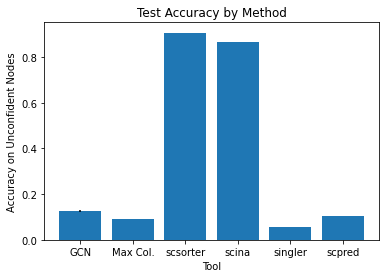

In [10]:
to_plot = results.loc[results['method']!="Confident Labels",:]
fig, ax = plt.subplots()
ax.bar(to_plot['method'],  to_plot['test_accuracy'], yerr= to_plot['test_sd'], align='center')
ax.set_xlabel("Tool")
ax.set_ylabel("Accuracy on Unconfident Nodes")
ax.set_title("Test Accuracy by Method")

Text(0.5, 1.0, 'Total Accuracy by Method')

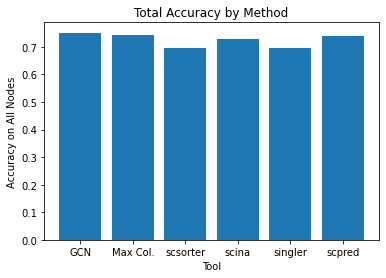

In [11]:
fig, ax = plt.subplots()
ax.bar(to_plot['method'],  to_plot['total_accuracy'], yerr= to_plot['total_sd'], align='center')
ax.set_xlabel("Tool")
ax.set_ylabel("Accuracy on All Nodes")
ax.set_title("Total Accuracy by Method")